In [2]:
!pip install folktables

You should consider upgrading via the '/home/denys_herasymuk/UCU/Studying_abroad/NYU_Internship/Code/RAI-summer-stability/RAI_venv/bin/python -m pip install --upgrade pip' command.


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
import sklearn
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pprint import pprint

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from utils.model_tuning_utils import test_ML_models

/home/denys_herasymuk/UCU/Studying_abroad/NYU_Internship/Code/RAI-summer-stability/RAI_venv/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/denys_herasymuk/UCU/Studying_abroad/NYU_Internship/Code/RAI-summer-stability/RAI_venv/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [5]:
%matplotlib inline

plt.style.use('mpl20')
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['figure.figsize'] = 15, 5

import warnings
warnings.filterwarnings('ignore')

### Python & Library Versions

In [6]:
versions = ( ("matplotlib", matplotlib.__version__),
             ("numpy", np.__version__),
             ("pandas", pd.__version__),
             ("sklearn", sklearn.__version__),
             ("seaborn", sns.__version__)
             )

print(sys.version, "\n")
print("library" + " " * 4 + "version")
print("-" * 18)

for tup1, tup2 in versions:
    print("{:11} {}".format(tup1, tup2))


3.8.10 (default, Mar 15 2022, 12:22:08) 
[GCC 9.4.0] 

library    version
------------------
matplotlib  3.5.2
numpy       1.21.2
pandas      1.3.3
sklearn     1.1.1
seaborn     0.11.2


### Read a dataset

In [7]:
from folktables import ACSDataSource, ACSEmployment

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["LA"], download=True)
features, label, group = ACSEmployment.df_to_numpy(acs_data)

### Data Pre-processing

In [8]:
ACSEmployment.target

'ESR'

In [9]:
ACSEmployment.features

['AGEP',
 'SCHL',
 'MAR',
 'RELP',
 'DIS',
 'ESP',
 'CIT',
 'MIG',
 'MIL',
 'ANC',
 'NATIVITY',
 'DEAR',
 'DEYE',
 'DREM',
 'SEX',
 'RAC1P']

In [10]:
features.shape, acs_data.shape

((43589, 16), (43589, 286))

In [11]:
# Create pandas datafrane with features and label column
full_df = acs_data[ACSEmployment.features + [ACSEmployment.target]].copy()
full_df.head()

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,ESR
0,29,18.0,5,16,2,NaN,1,1.0,4.0,2,1,2,2,2.0,1,1,6.0
1,17,13.0,5,16,2,NaN,1,1.0,4.0,1,1,2,2,2.0,1,2,6.0
2,37,13.0,5,16,2,NaN,1,1.0,4.0,1,1,2,2,2.0,1,1,6.0
3,86,12.0,2,16,1,NaN,1,1.0,4.0,1,1,2,1,2.0,2,2,6.0
4,22,19.0,5,17,2,NaN,1,1.0,4.0,1,1,2,2,2.0,2,1,6.0


In [12]:
# Convert label column to binary format
full_df['LABEL_ESR'] = ACSEmployment.target_transform(full_df[ACSEmployment.target])
full_df.drop([ACSEmployment.target], axis=1, inplace=True)

In [13]:
full_df['AGEP'].describe()

count    43589.000000
mean        41.764344
std         23.701184
min          0.000000
25%         21.000000
50%         42.000000
75%         61.000000
max         93.000000
Name: AGEP, dtype: float64

In [13]:
full_df.isnull().sum()

AGEP             0
SCHL          1366
MAR              0
RELP             0
DIS              0
ESP          35401
CIT              0
MIG            451
MIL           8237
ANC              0
NATIVITY         0
DEAR             0
DEYE             0
DREM          2314
SEX              0
RAC1P            0
LABEL_ESR        0
dtype: int64

In [14]:
full_df.fillna(0, inplace = True)
full_df.isnull().sum()

AGEP         0
SCHL         0
MAR          0
RELP         0
DIS          0
ESP          0
CIT          0
MIG          0
MIL          0
ANC          0
NATIVITY     0
DEAR         0
DEYE         0
DREM         0
SEX          0
RAC1P        0
LABEL_ESR    0
dtype: int64

### Data Profiling

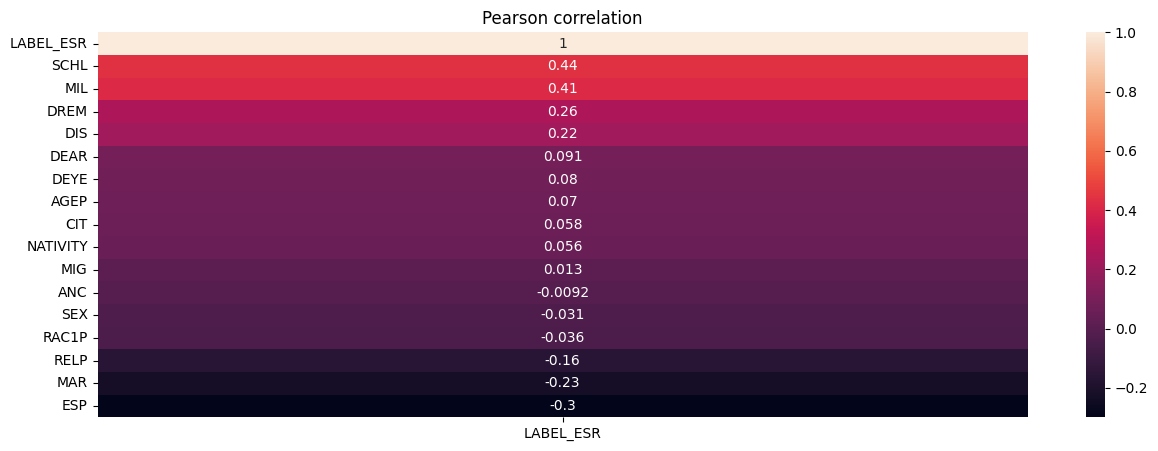

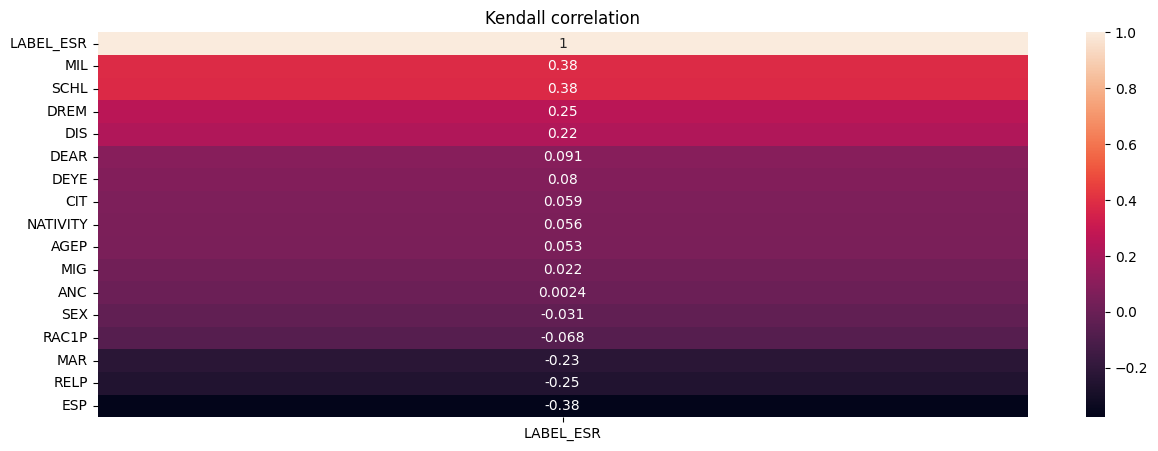

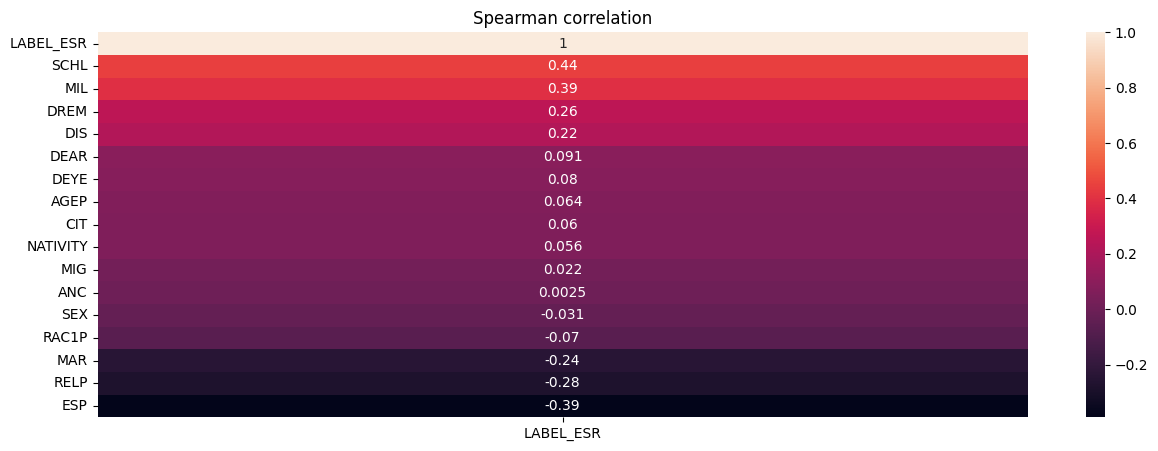

In [15]:
# Look at feature correlation with 'LABEL' column
for method in ['pearson', 'kendall', 'spearman']:
    ax = plt.axes()
    sns.heatmap(
        full_df.corr(method=method)[['LABEL_ESR']]\
            .sort_values(by='LABEL_ESR', ascending=False),
        ax=ax,
        annot=True
    )
    ax.set_title(f'{method.capitalize()} correlation')
    plt.show()


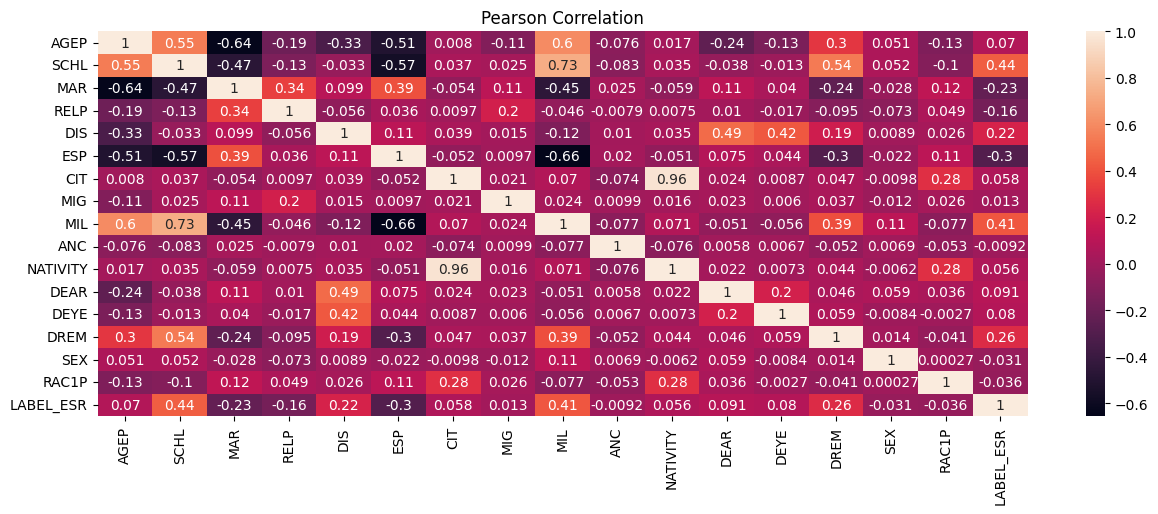

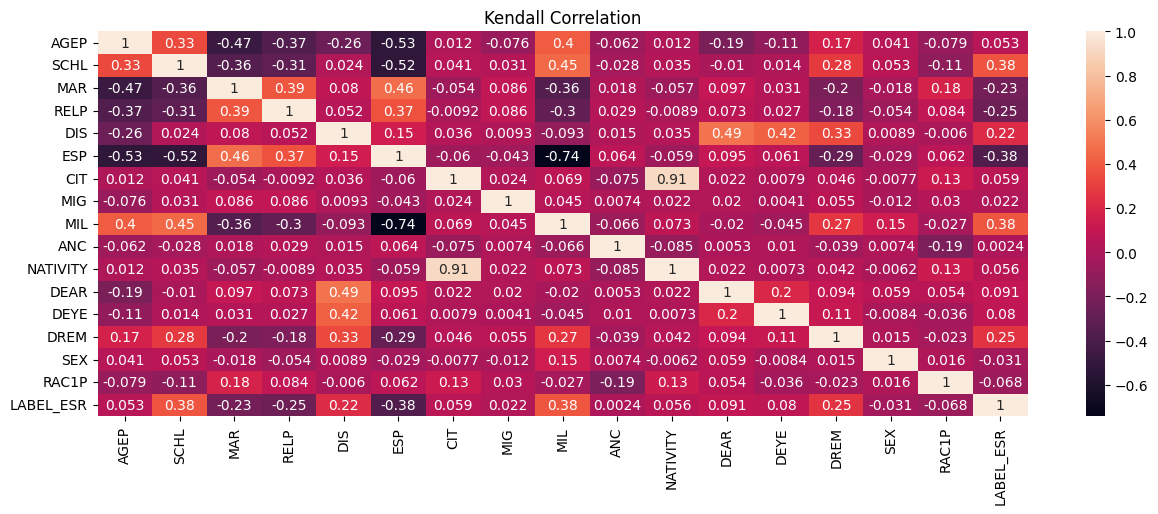

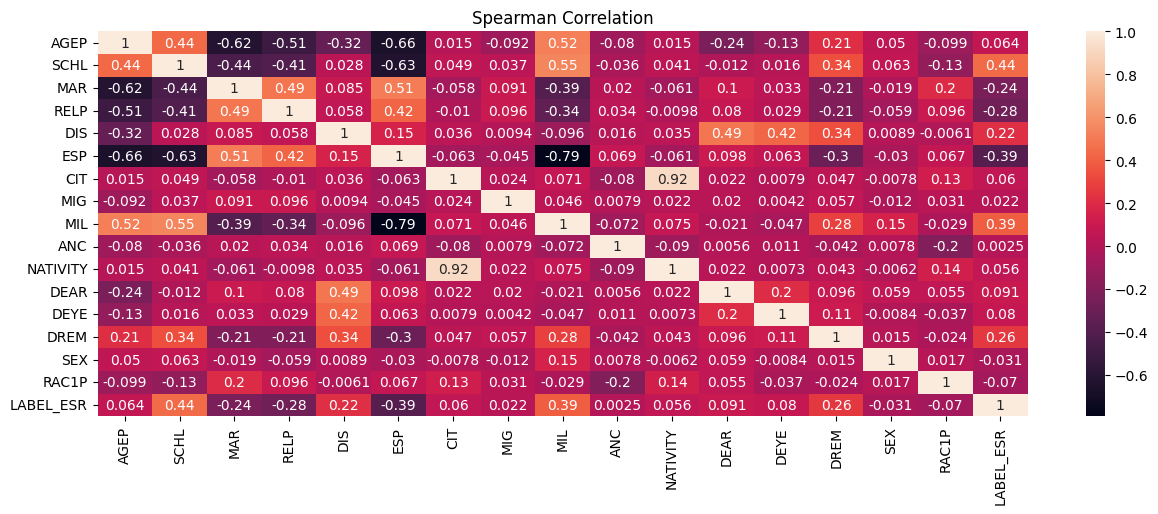

In [16]:
# Look at correlations among features
for method in ['pearson', 'kendall', 'spearman']:
    ax = plt.axes()
    sns.heatmap(full_df.corr(method=method), ax=ax, annot=True)
    ax.set_title(f'{method.capitalize()} Correlation')
    plt.show()


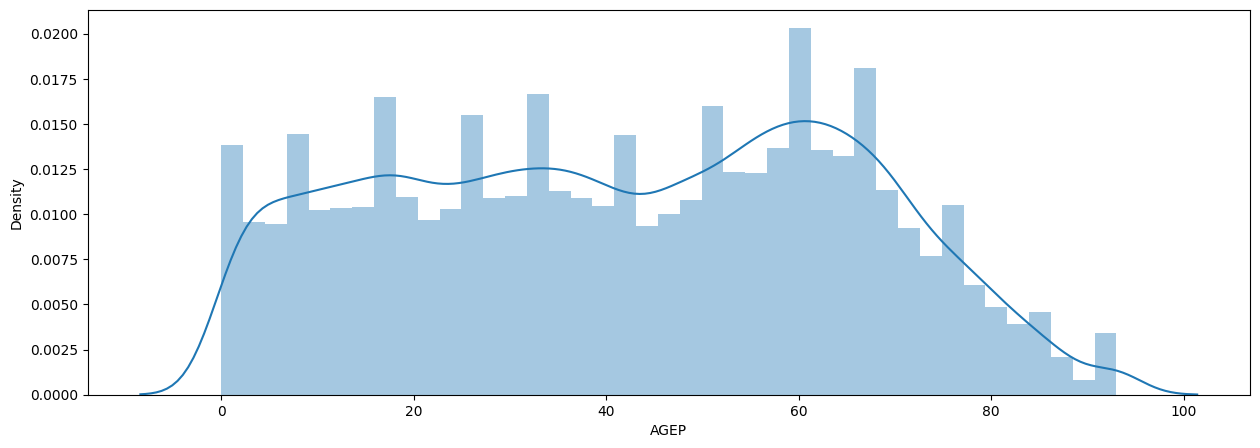

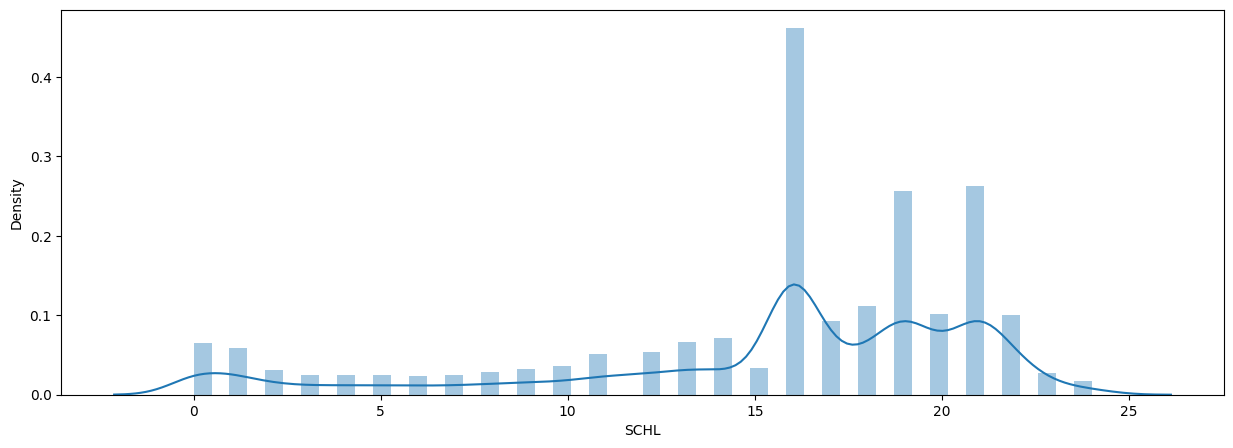

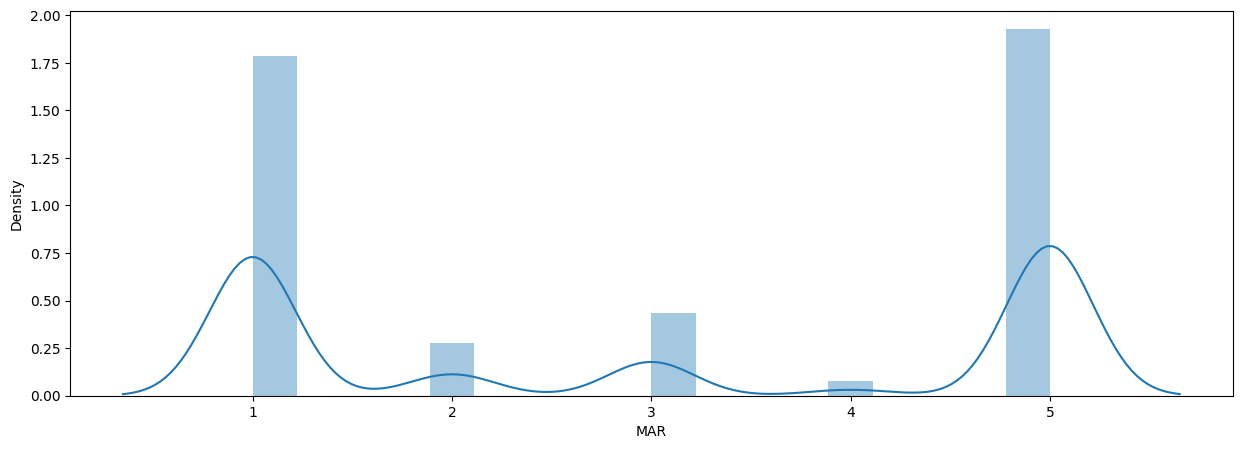

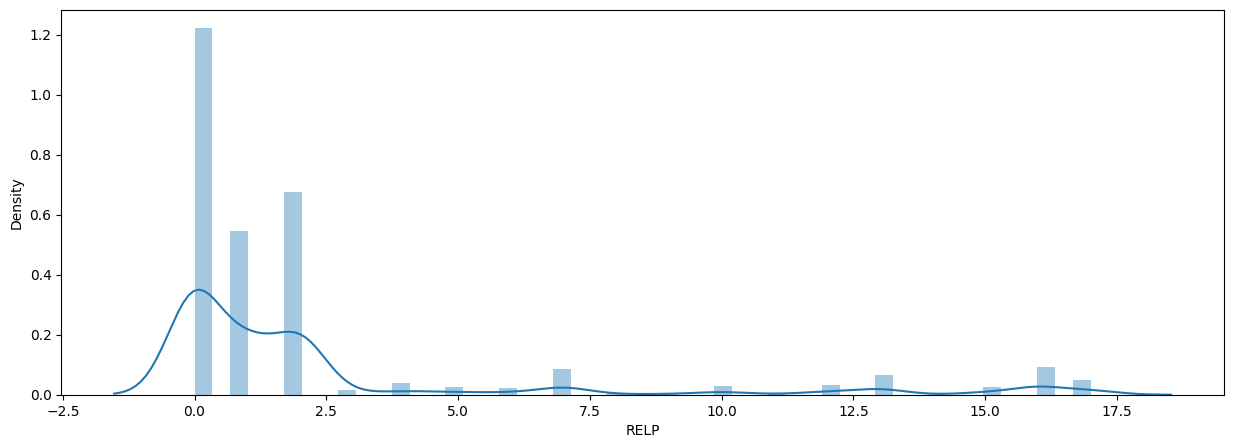

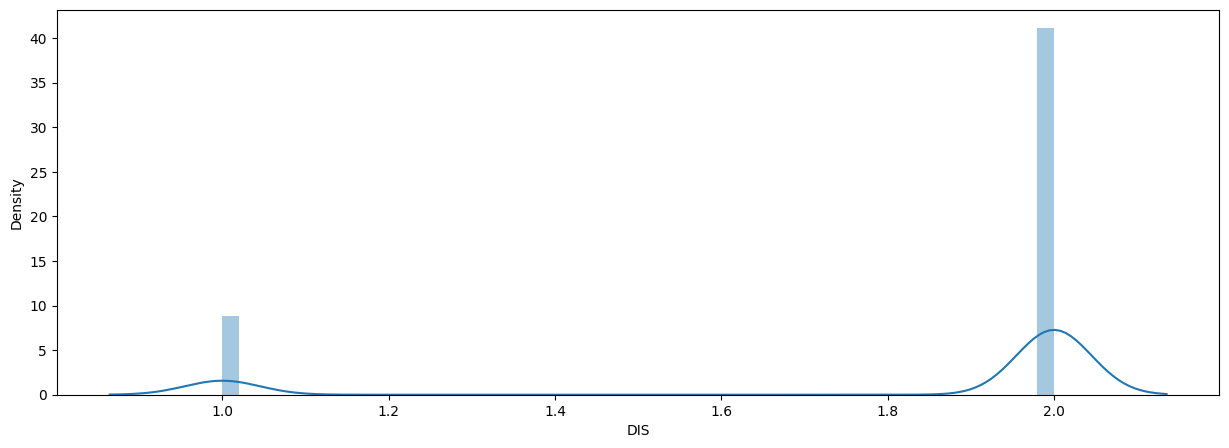

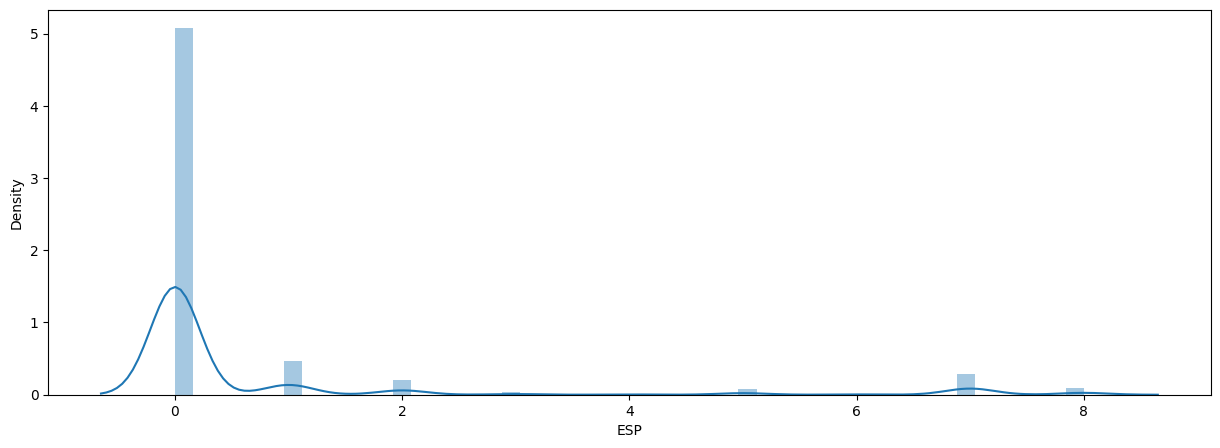

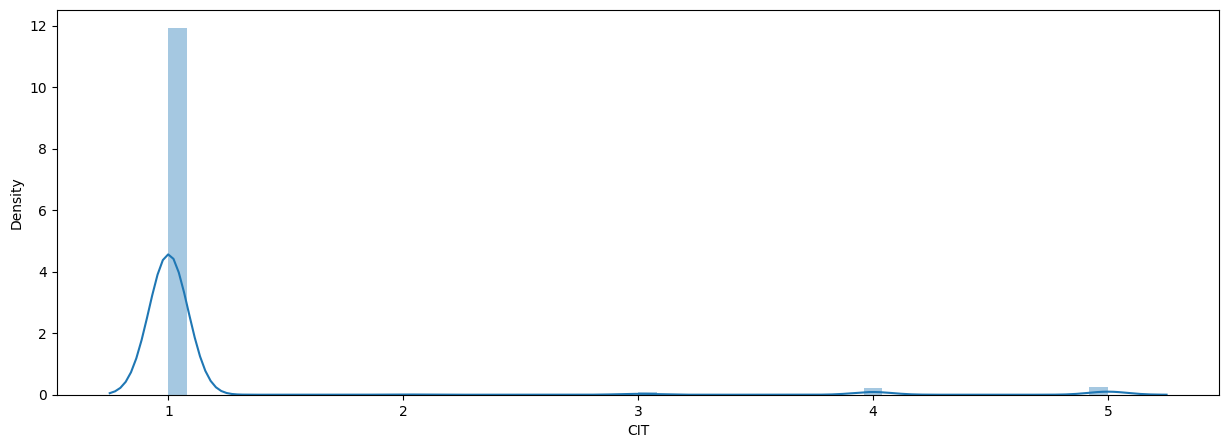

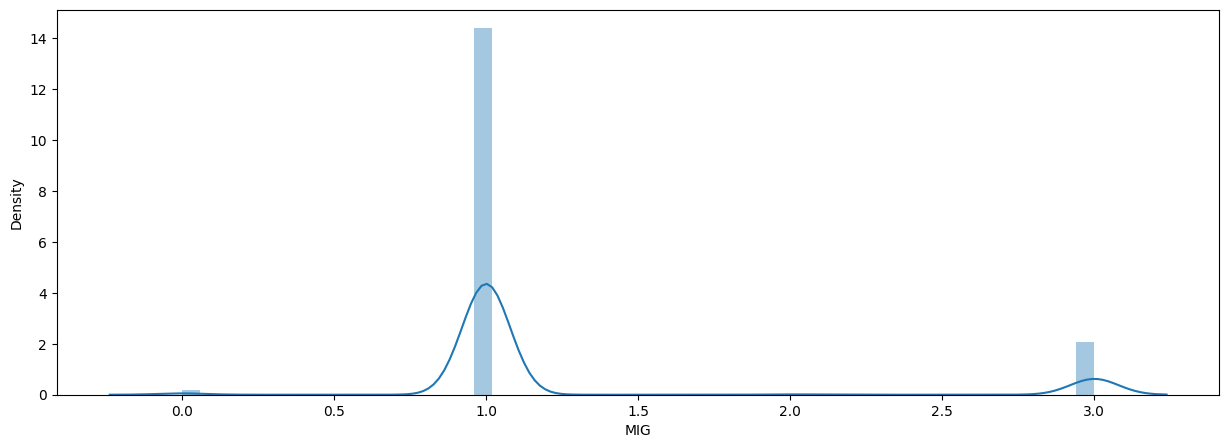

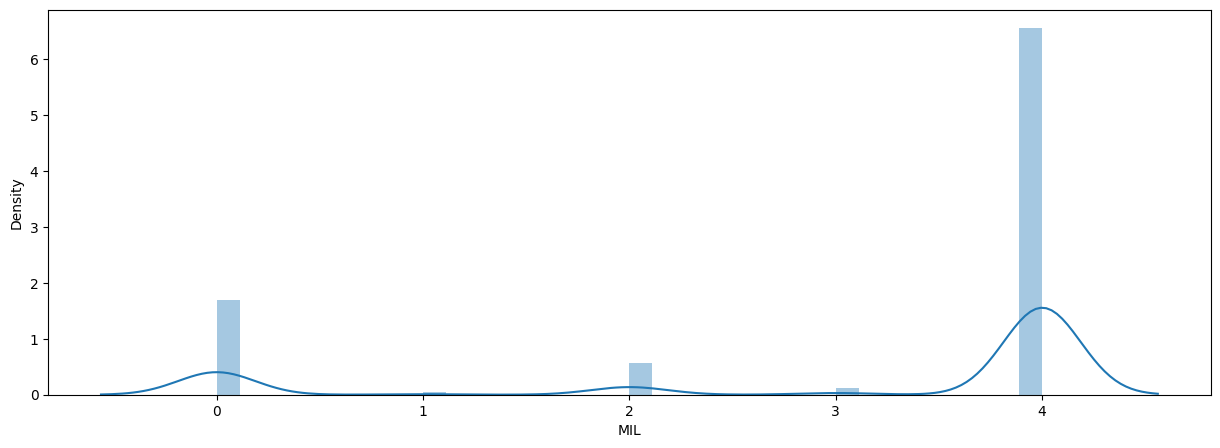

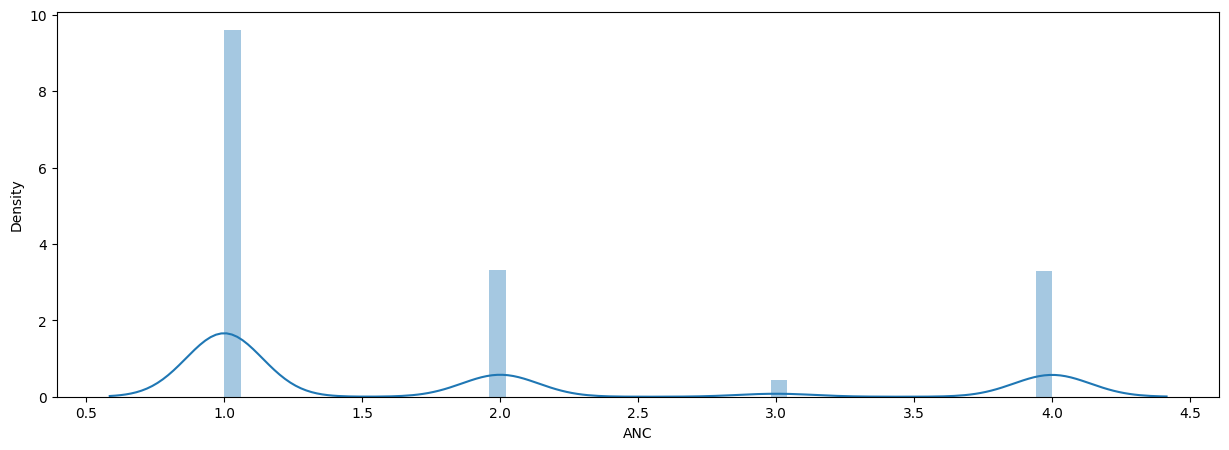

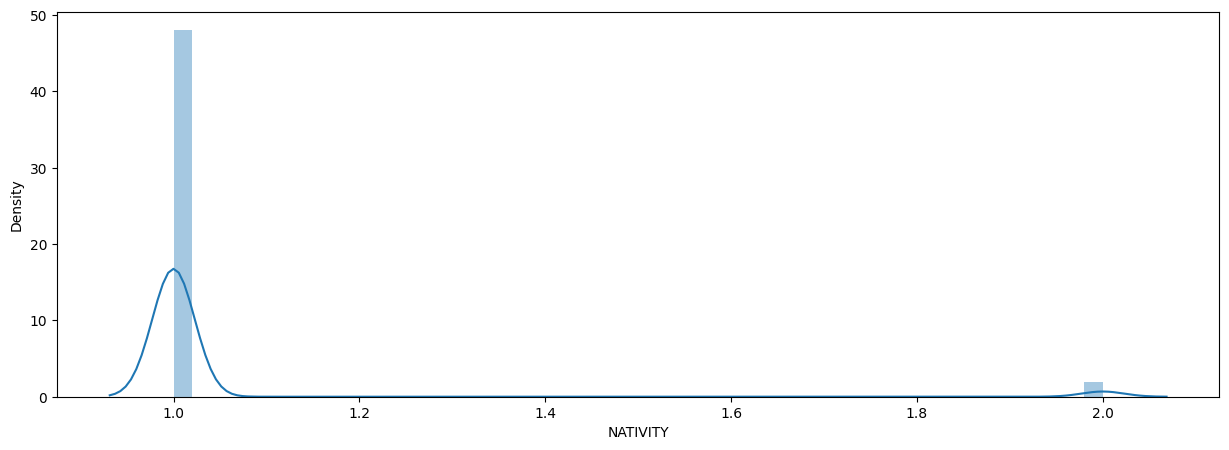

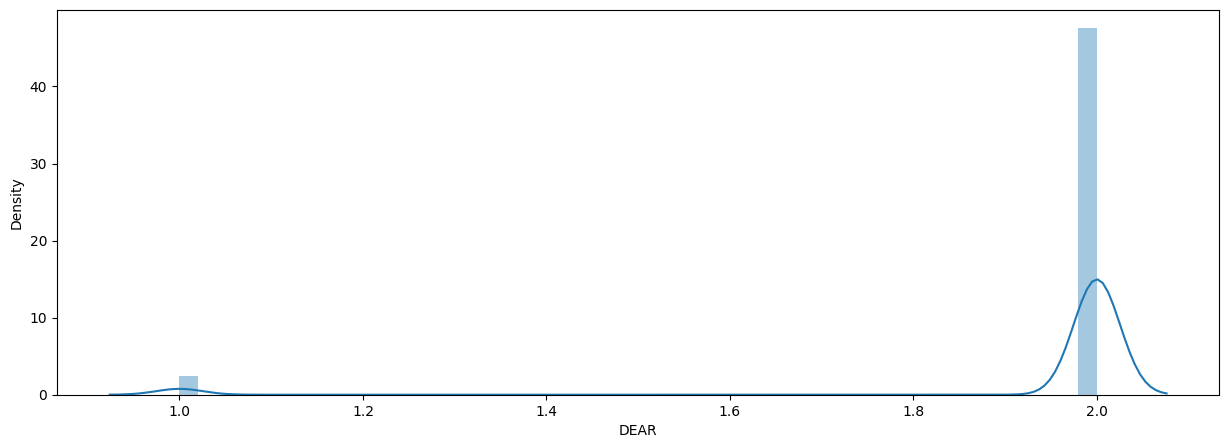

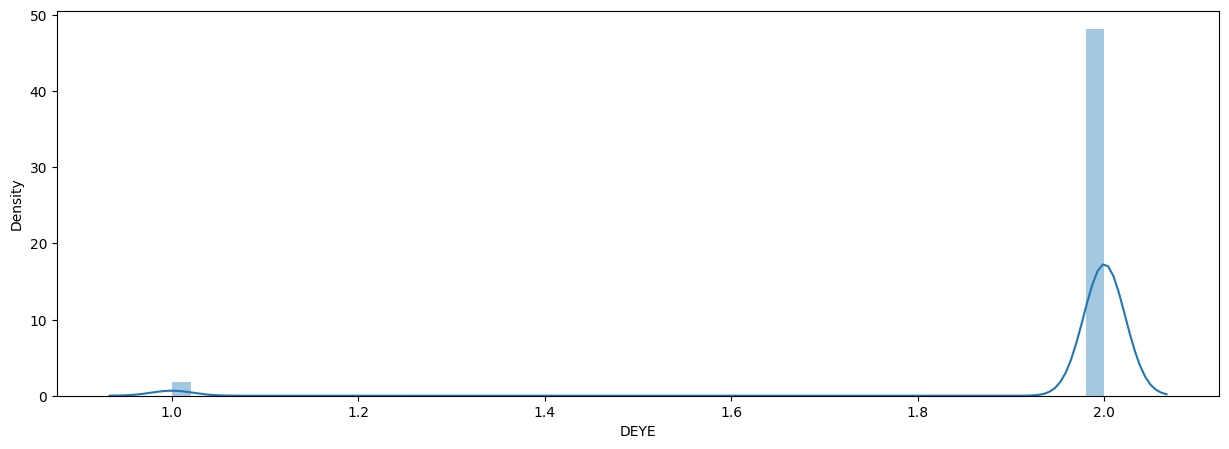

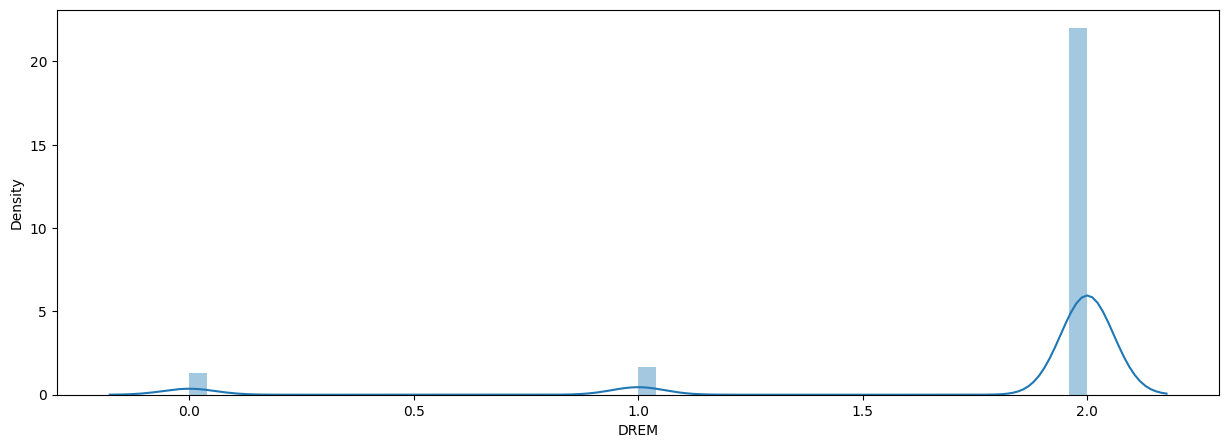

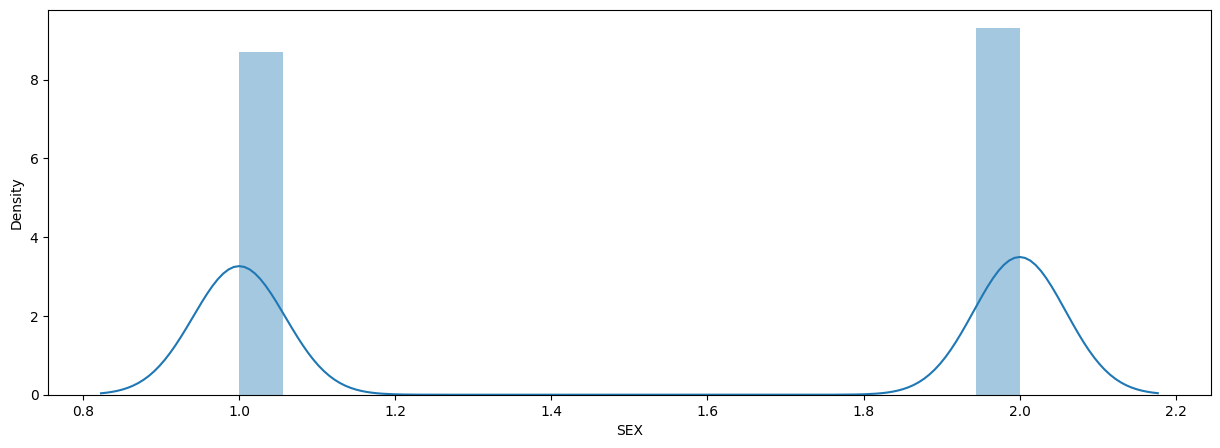

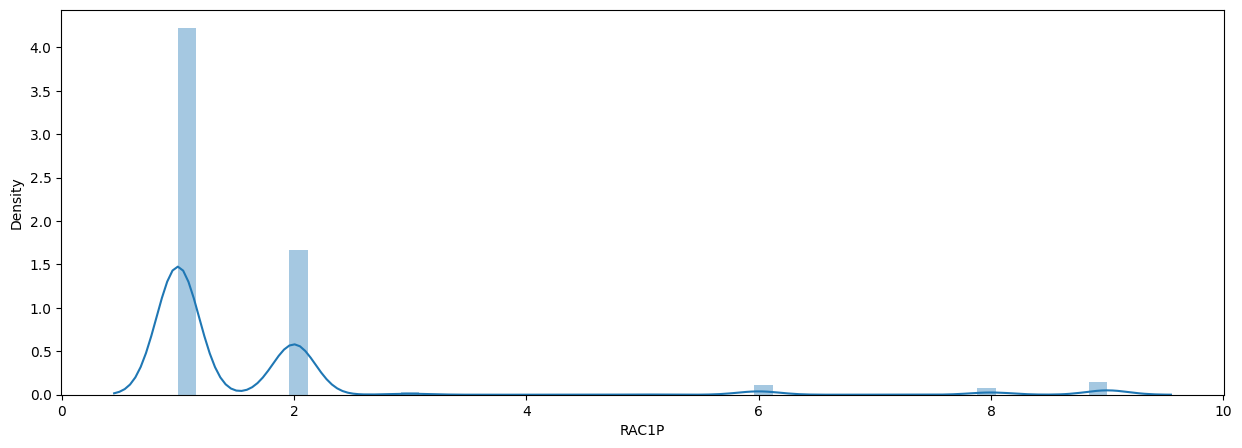

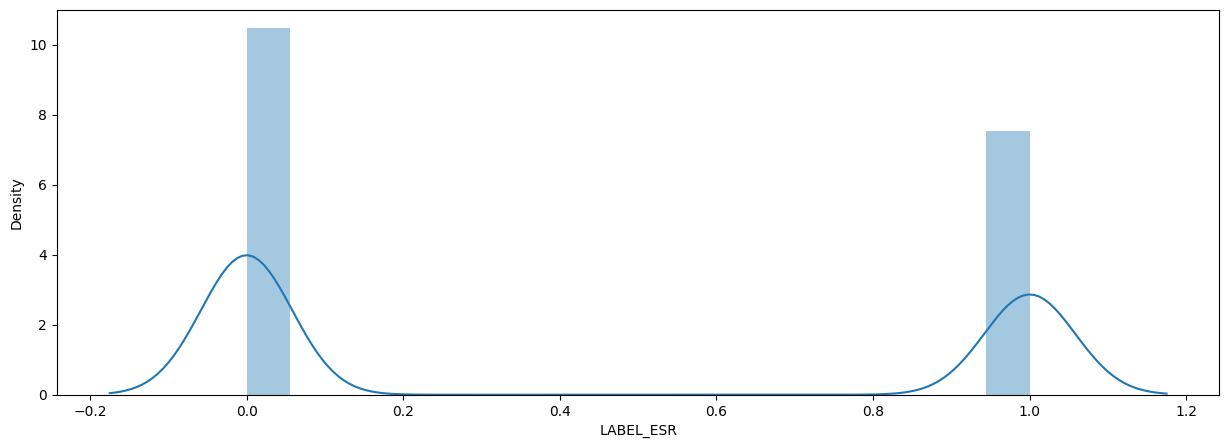

In [17]:
# Look at densities of each column
for column in full_df.columns:
    plt.figure()
    sns.distplot(full_df[column])

### Train a baseline model

In [24]:
SEED = 42
feature_cols = ['SCHL', 'MIL', 'DREM', 'DIS', 'MAR', 'RELP', 'ESP']
features_df = pd.get_dummies(full_df[feature_cols], columns=feature_cols)
target_df = full_df['LABEL_ESR']
features_df.head()

,SCHL_1.0,SCHL_2.0,SCHL_3.0,SCHL_4.0,SCHL_5.0,SCHL_6.0,SCHL_7.0,SCHL_8.0,SCHL_9.0,SCHL_10.0,...,RELP_16,RELP_17,ESP_1.0,ESP_2.0,ESP_3.0,ESP_4.0,ESP_5.0,ESP_6.0,ESP_7.0,ESP_8.0
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [25]:
X_train, X_test, y_train, y_test = train_test_split(features_df, target_df, test_size=0.2, random_state=SEED)
X_train.shape, X_test.shape

((34871, 63), (8718, 63))

In [20]:
n_folds = 3
samples_per_fold = len(y_test)
best_results_df = pd.DataFrame(columns=('Dataset_Name', 'Model_Name', 'F1_Score',
                                   'Accuracy_Score',
                                   'Model_Best_Params', 'Model_Pred'))

In [21]:
config_models = [
    {
        'model_name': 'RandomForestClassifier',
        'model': RandomForestClassifier(random_state=SEED),
        'params': {
            "bootstrap": [True, False],
            "max_depth": [3, 4, 6, 10],
            "n_estimators": [5 * i for i in range(1, 7)],
            "max_features": [0.6]
        }
    },
    {
        'model_name': 'DecisionTreeClassifier',
        'model': DecisionTreeClassifier(random_state=SEED),
        'params': {
            "max_depth": [2, 3, 4, 6, 10],
            "min_samples_split": [2, 6],
            "min_samples_leaf": [1, 2, 4],
            "max_features": [0.6, 'sqrt'],
            "criterion": ["gini", "entropy"]
        }
    },
    # For XGBoost parameters tuning we used this article --
    # https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
    {
        'model_name': 'XGBClassifier',
        'model': XGBClassifier(random_state=SEED),
        'params': {
            'learning_rate': [0.1, 0.01],
            'n_estimators': [100, 200],
            'max_depth': range(3, 10, 2),
            'objective':  ['binary:logistic'],
        }
    }
]

Tuning for RandomForestClassifier is finished
####################  Folktables [LA]  ####################
Test model:  RandomForestClassifier
Test model parameters:
{'bootstrap': True, 'max_depth': 10, 'max_features': 0.6, 'n_estimators': 30}

              precision    recall  f1-score   support

       False      0.872     0.675     0.761      5171
        True      0.643     0.856     0.734      3547

    accuracy                          0.748      8718
   macro avg      0.758     0.765     0.748      8718
weighted avg      0.779     0.748     0.750      8718



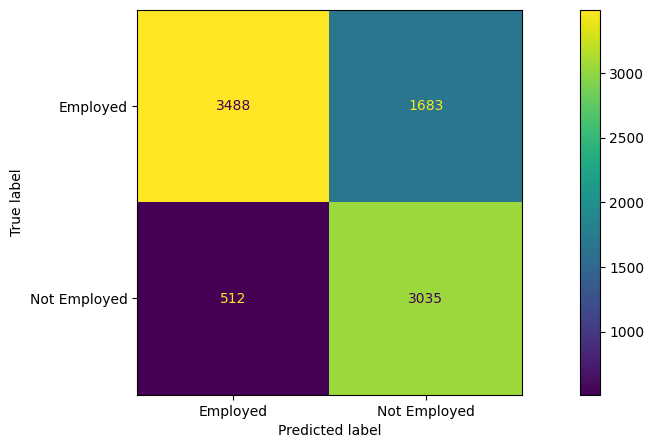

Tuning for DecisionTreeClassifier is finished
####################  Folktables [LA]  ####################
Test model:  DecisionTreeClassifier
Test model parameters:
{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 0.6,
 'min_samples_leaf': 2,
 'min_samples_split': 6}

              precision    recall  f1-score   support

       False      0.856     0.682     0.759      5171
        True      0.643     0.833     0.726      3547

    accuracy                          0.744      8718
   macro avg      0.750     0.758     0.743      8718
weighted avg      0.769     0.744     0.746      8718



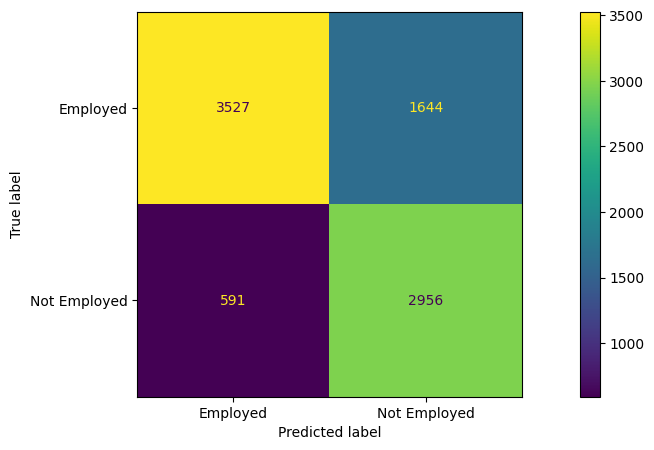

Tuning for XGBClassifier is finished
####################  Folktables [LA]  ####################
Test model:  XGBClassifier
Test model parameters:
{'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 200,
 'objective': 'binary:logistic'}

              precision    recall  f1-score   support

       False      0.861     0.697     0.770      5171
        True      0.654     0.836     0.734      3547

    accuracy                          0.753      8718
   macro avg      0.758     0.766     0.752      8718
weighted avg      0.777     0.753     0.756      8718



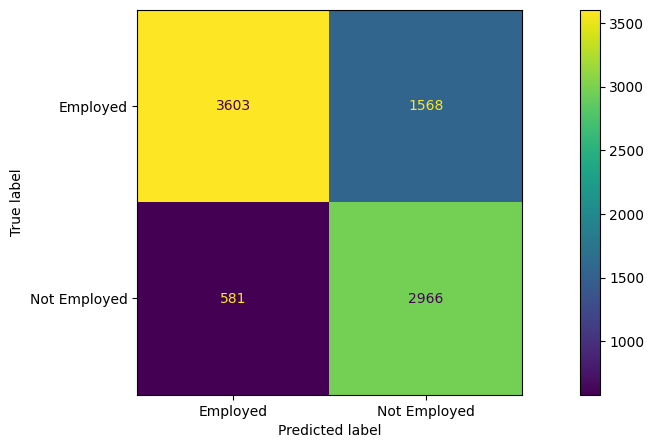

,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,Folktables [LA],RandomForestClassifier,0.747540,0.748222,"{'bootstrap': True, 'max_depth': 10, 'max_feat..."
1,Folktables [LA],DecisionTreeClassifier,0.742529,0.743634,"{'criterion': 'gini', 'max_depth': 10, 'max_fe..."
2,Folktables [LA],XGBClassifier,0.752175,0.753499,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."


In [22]:
ML_results_df = test_ML_models(best_results_df, config_models, n_folds, samples_per_fold,
                               X_train, y_train, X_test, y_test, "Folktables [LA]", show_plots=True, debug_mode=True)
ML_results_df

In [23]:
for index, row in ML_results_df.iterrows():
  print(f'\n\nModel name: {row["Model_Name"]}')
  pprint(row['Model_Best_Params'])



Model name: RandomForestClassifier
{'bootstrap': True, 'max_depth': 10, 'max_features': 0.6, 'n_estimators': 30}


Model name: DecisionTreeClassifier
{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 0.6,
 'min_samples_leaf': 2,
 'min_samples_split': 6}


Model name: XGBClassifier
{'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 200,
 'objective': 'binary:logistic'}
